In [9]:
import sys
import numpy as np
import numpy.random as rand

import ufl
from dolfinx import fem, io, mesh, plot
from ufl import ds, dx, grad, inner
from mpi4py import MPI
from petsc4py.PETSc import ScalarType

from datetime import datetime
import h5py


import matplotlib.pyplot as plt


In [10]:
def harris_dP_dA(B, d, x):
    """
    Calculates the RHS of the grad-shafranov eqn for a harris current sheet.
    
    Parameters:
    -----------
    
    B : array-like of floats
        The characteristic magnetic field. Non-constant for perturbed harris
    d : array-like of floats
        characteristic thickness of the magnetic field, varies for perturbed harris
    x : array-like of floats
        distance from x=0 line. Varies for perturbed harris.
        
    Returns:
    --------
    dP_dA: RHS of grad-shafranov for perturbed harris sheet.
    """
    
    dP_dA = -1*B/d*ufl.cosh(x/d)**(-2)
    return dP_dA

def harris_dP_dA_np(B, d, x):
    """
    Calculates the RHS of the grad-shafranov eqn for a harris current sheet.
    
    Parameters:
    -----------
    
    B : array-like of floats
        The characteristic magnetic field. Non-constant for perturbed harris
    d : array-like of floats
        characteristic thickness of the magnetic field, varies for perturbed harris
    x : array-like of floats
        distance from x=0 line. Varies for perturbed harris.
        
    Returns:
    --------
    dP_dA: RHS of grad-shafranov for perturbed harris sheet.
    """
    
    dP_dA = -1*B/d*np.cosh(x/d)**(-2)
    return dP_dA

In [11]:
def bdy_finder_generator(bdy_bleft, bdy_tright):
    """ generator function so bdy_finder depends only on x (as dolfinx needs) but is
        flexible to defining what the boundaries actually are"""
    def bdy_finder(x):
       
        bdy = np.any([np.isclose(x[0], bdy_bleft[0]),
                            np.isclose(x[0], bdy_tright[0]),
                            np.isclose(x[1], bdy_bleft[1]),
                            np.isclose(x[1], bdy_tright[1])], axis=0)
        return bdy
    return bdy_finder

In [12]:
def harris_bc_gen(d_0, B_0):
    """Makes function to determine dirichlet boundary conditions for harris sheet for Ay """
    def harris_bc(x):
        bdy_val = d_0*B_0*np.log(np.cosh(x[1]/d_0))
        return bdy_val
    return harris_bc

def harris_bc_gen_p(d_0, B_0, mu_0):
    """Makes function to determine dirichlet boundary conditions for harris sheet for pressure
    should be p = integral(jy*Bx) with p->0 as y->inf"""
    def harris_bc_p(x):
        bdy_val = B_0**2/(2*mu_0)*np.cosh(x[1]/d_0)**(-2)
        return bdy_val
    return harris_bc_p

In [13]:
bdy_bleft = (-100.0, -25.0)
bdy_tright = (100.0, 25.0)
d_0 = 2.
B_0 = 1.  # magnetic field strength MUST BE 1 FOR PROPER FORCE BALANCE LATER B is scaled by wcewpe

nsquares = (512, 256)

msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=(bdy_bleft, bdy_tright), n=nsquares,
                            cell_type=mesh.CellType.triangle,)

V = fem.FunctionSpace(msh, ("CG", 1))
facets = mesh.locate_entities_boundary(msh, dim=1,
                                       marker=bdy_finder_generator(bdy_bleft, bdy_tright))
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
bd_fn = harris_bc_gen(d_0, B_0)
har_bc = fem.Function(V, dtype=ScalarType)
har_bc.interpolate(bd_fn)
bc = fem.dirichletbc(value=har_bc, dofs=dofs)

In [14]:
# DO: Varying B, varying d, wiggly x, regular harris
x_wiggle = lambda x: x[1] + 10*ufl.cos(2*np.pi*x[0]/(bdy_tright[0] - bdy_bleft[0]))
b_wiggle = lambda x: B_0*(1 + .3*ufl.sin(2*np.pi*x[0]/(bdy_tright[0] - bdy_bleft[0])))
d_wiggle = lambda x: d_0*(1 + .3*ufl.sin(2*np.pi*x[0]/(bdy_tright[0] - bdy_bleft[0])))

x_wiggle_np = lambda x: x[:,1] + 10*np.cos(2*np.pi*x[:,0]/(bdy_tright[0] - bdy_bleft[0]))
b_wiggle_np = lambda x: B_0*(1 + .3*np.sin(2*np.pi*x[:,0]/(bdy_tright[0] - bdy_bleft[0])))
d_wiggle_np = lambda x: d_0*(1 + .3*np.sin(2*np.pi*x[:,0]/(bdy_tright[0] - bdy_bleft[0])))

# can reuse these for multiple solves
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)

# normal harris
f_normal = harris_dP_dA(B_0,d_0, x[1])  # defined as laplace A = -f
a_normal = inner(grad(u), grad(v)) * dx
L_normal = inner(f_normal, v) * dx 
problem_normal = fem.petsc.LinearProblem(a_normal, L_normal, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
soln_normal = problem_normal.solve()
dp_da_normal = harris_dP_dA_np(B_0, d_0, msh.geometry.x[:,1])
Ay_normal = soln_normal.x.array.real

# wiggly B
f_bvar = harris_dP_dA(b_wiggle(x),d_0, x[1])  # defined as laplace A = -f
a_bvar = inner(grad(u), grad(v)) * dx
L_bvar = inner(f_bvar, v) * dx 
problem_bvar = fem.petsc.LinearProblem(a_bvar, L_bvar, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
soln_bvar = problem_bvar.solve()
dp_da_bvar = harris_dP_dA_np(b_wiggle_np(msh.geometry.x), d_0, msh.geometry.x[:,1])
Ay_bvar = soln_bvar.x.array.real

# wiggly d
f_dvar = harris_dP_dA(B_0,d_wiggle(x), x[1])  # defined as laplace A = -f
a_dvar = inner(grad(u), grad(v)) * dx
L_dvar = inner(f_dvar, v) * dx 
problem_dvar = fem.petsc.LinearProblem(a_dvar, L_dvar, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
soln_dvar = problem_dvar.solve()
dp_da_dvar = harris_dP_dA_np(B_0, d_wiggle_np(msh.geometry.x), msh.geometry.x[:,1])
Ay_dvar = soln_dvar.x.array.real

# wiggly x
f_xvar = harris_dP_dA(B_0,d_0, x_wiggle(x))  # defined as laplace A = -f
a_xvar = inner(grad(u), grad(v)) * dx
L_xvar = inner(f_xvar, v) * dx 
problem_xvar = fem.petsc.LinearProblem(a_xvar, L_xvar, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
soln_xvar = problem_xvar.solve()
dp_da_xvar = harris_dP_dA_np(B_0, d_0, x_wiggle_np(msh.geometry.x))
Ay_xvar = soln_xvar.x.array.real

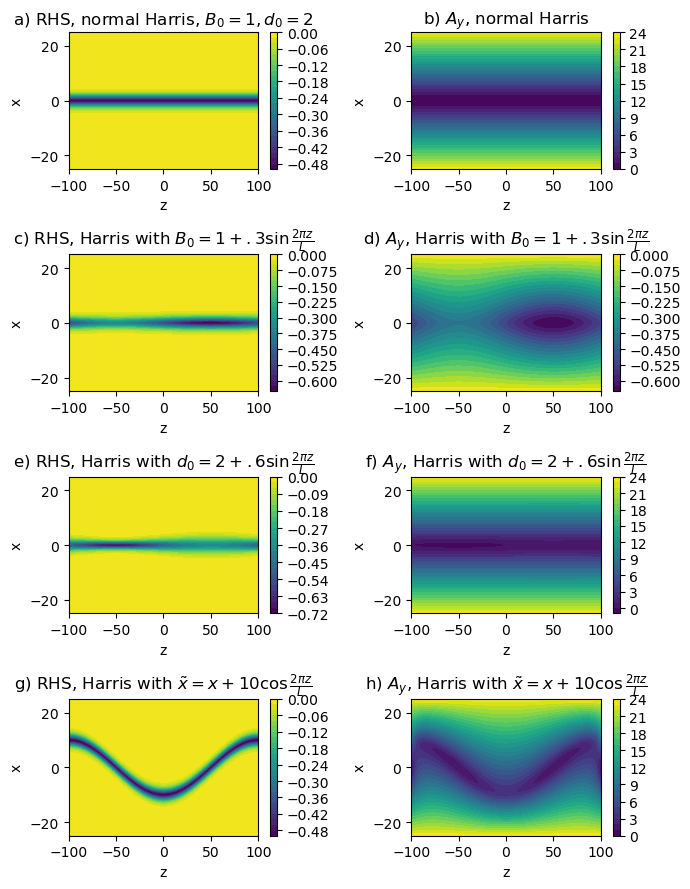

In [ ]:
fig,ax = plt.subplots(nrows=4, ncols=2,figsize=(7,9))
levels = 25
ylims = (-25,25)
plt.rcParams['contour.negative_linestyle'] = 'solid'

normalrhs = ax[0,0].tricontourf(msh.geometry.x[:,0], msh.geometry.x[:,1], dp_da_normal, levels=levels)
ax[0,0].set(title=r"a) RHS, normal Harris, $B_0=1, d_0=2$", xlabel='z', ylabel='x')
ax[0,0].set_ylim(*ylims)
fig.colorbar(normalrhs, ax=ax[0,0])

normalA = ax[0,1].tricontourf(msh.geometry.x[:,0], msh.geometry.x[:,1], Ay_normal, levels=levels)
ax[0,1].set(title=r"b) $A_y$, normal Harris", xlabel='z', ylabel='x')
ax[0,1].set_ylim(*ylims) 
fig.colorbar(normalA, ax=ax[0,1])

wigglebrhs = ax[1,0].tricontourf(msh.geometry.x[:,0], msh.geometry.x[:,1], dp_da_bvar, levels=levels)
ax[1,0].set(title=r"c) RHS, Harris with $B_0 = 1 + .3\sin{\frac{2\pi z}{L}}$", xlabel='z', ylabel='x')
ax[1,0].set_ylim(*ylims)
fig.colorbar(wigglebrhs, ax=ax[1,0])

wigglebA = ax[1,1].tricontourf(msh.geometry.x[:,0], msh.geometry.x[:,1], Ay_bvar, levels=levels)
ax[1,1].set(title=r"d) $A_y$, Harris with $B_0=1 + .3\sin{\frac{2\pi z}{L}}$", xlabel='z', ylabel='x')
ax[1,1].set_ylim(*ylims)
fig.colorbar(wigglebrhs, ax=ax[1,1])

wiggledrhs = ax[2,0].tricontourf(msh.geometry.x[:,0], msh.geometry.x[:,1], dp_da_dvar, levels=levels)
ax[2,0].set(title=r"e) RHS, Harris with $d_0= 2 + .6\sin{\frac{2\pi z}{L}}$", xlabel='z', ylabel='x')
ax[2,0].set_ylim(*ylims)
fig.colorbar(wiggledrhs, ax=ax[2,0])

wiggledA = ax[2,1].tricontourf(msh.geometry.x[:,0], msh.geometry.x[:,1], Ay_dvar, levels=levels)
ax[2,1].set(title=r"f) $A_y$, Harris with $d_0=2 + .6\sin{\frac{2\pi z}{L}}$", xlabel='z', ylabel='x')
ax[2,1].set_ylim(*ylims)
fig.colorbar(wiggledA, ax=ax[2,1])

wigglexrhs = ax[3,0].tricontourf(msh.geometry.x[:,0], msh.geometry.x[:,1], dp_da_xvar, levels=levels)
ax[3,0].set(title=r"g) RHS, Harris with $\tilde{x} = x + 10\cos{\frac{2\pi z}{L}}$", xlabel='z', ylabel='x')
ax[3,0].set_ylim(*ylims)
fig.colorbar(wigglexrhs, ax=ax[3,0])

wigglexA = ax[3,1].tricontourf(msh.geometry.x[:,0], msh.geometry.x[:,1], Ay_xvar, levels=levels)
ax[3,1].set(title=r"h) $A_y$, Harris with $\tilde{x} = x + 10\cos{\frac{2\pi z}{L}}$", xlabel='z', ylabel='x')
ax[3,1].set_ylim(*ylims)
fig.colorbar(wigglexA, ax=ax[3,1])

fig.tight_layout()
plt.show()
fig.savefig("/tigress/kendrab/analysis-notebooks/grad_shaf_outputs/testing/perturbed_image_examples.svg")
plt.close(fig='all')